In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

In [12]:
# Trader = historical trade data
trader = pd.read_csv("historical_data.csv")

# Sentiment = fear greed index
sentiment = pd.read_csv("fear_greed_index.csv")

print("Trader shape:", trader.shape)
print("Sentiment shape:", sentiment.shape)

Trader shape: (211224, 16)
Sentiment shape: (2644, 4)


In [14]:
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')
sentiment = sentiment.dropna(subset=['date'])
sentiment['date'] = sentiment['date'].dt.date

In [15]:
trader['timestamp ist'] = pd.to_datetime(
    trader['timestamp ist'],
    dayfirst=True,
    errors='coerce'
)

trader = trader.dropna(subset=['timestamp ist'])
trader['date'] = trader['timestamp ist'].dt.date

In [16]:
numeric_cols = [
    'execution price',
    'size tokens',
    'size usd',
    'closed pnl',
    'fee'
]

for col in numeric_cols:
    if col in trader.columns:
        trader[col] = pd.to_numeric(trader[col], errors='coerce')

In [17]:
merged = trader.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

print("Missing sentiment rows:", merged['classification'].isna().sum())
print("Total rows:", len(merged))

Missing sentiment rows: 6
Total rows: 211224


In [18]:
merged['win'] = (merged['closed pnl'] > 0).astype(int)

ANALYSIS

In [19]:
#pnl by sentiment

pnl_by_sentiment = (
    merged
    .groupby('classification')['closed pnl']
    .agg(['mean','median','std','count'])
    .reset_index()
)

pnl_by_sentiment

,classification,mean,median,std,count
0,Extreme Fear,34.537862,0.0,1136.056091,21400
1,Extreme Greed,67.892861,0.0,766.828294,39992
2,Fear,54.290400,0.0,935.355438,61837
3,Greed,42.743559,0.0,1116.028390,50303
4,Neutral,34.307718,0.0,517.122220,37686


In [20]:
#win rate by sentiment

win_rate_by_sentiment = (
    merged
    .groupby('classification')['win']
    .mean()
    .reset_index()
)

win_rate_by_sentiment

,classification,win
0,Extreme Fear,0.370607
1,Extreme Greed,0.464943
2,Fear,0.420768
3,Greed,0.384828
4,Neutral,0.396991


In [21]:
#Anova Test

from scipy.stats import f_oneway

groups = [
    group['closed pnl'].dropna()
    for name, group in merged.groupby('classification')
]

anova_result = f_oneway(*groups)

print("F-statistic:", anova_result.statistic)
print("P-value:", anova_result.pvalue)

F-statistic: 9.062225672396849
P-value: 2.5753989849026544e-07


In [23]:
#Effect Size

overall_mean = merged['closed pnl'].mean()

ss_between = sum(
    len(group) * (group.mean() - overall_mean) ** 2
    for name, group in merged.groupby('classification')['closed pnl']
)

ss_total = sum((merged['closed pnl'] - overall_mean) ** 2)

eta_squared = ss_between / ss_total

print("Eta Squared:", eta_squared)

Eta Squared: 0.00017119694717784034


In [24]:
#Turkey Post-Hoc

from statsmodels.stats.multicomp import pairwise_tukeyhsd

anova_data = merged.dropna(subset=['classification'])

tukey = pairwise_tukeyhsd(
    endog=anova_data['closed pnl'],
    groups=anova_data['classification'],
    alpha=0.05
)

print(tukey)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1        group2    meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------
 Extreme Fear Extreme Greed   33.355 0.0002  12.1482  54.5618   True
 Extreme Fear          Fear  19.7525  0.052  -0.1057  39.6108  False
 Extreme Fear         Greed   8.2057 0.8091 -12.2295  28.6409  False
 Extreme Fear       Neutral  -0.2301    1.0 -21.6619  21.2017  False
Extreme Greed          Fear -13.6025 0.1418 -29.6696   2.4647  False
Extreme Greed         Greed -25.1493 0.0004 -41.9243  -8.3743   True
Extreme Greed       Neutral -33.5851    0.0 -51.5608 -15.6095   True
         Fear         Greed -11.5468 0.2221 -26.5808   3.4871  False
         Fear       Neutral -19.9827 0.0077 -36.3456  -3.6198   True
        Greed       Neutral  -8.4358 0.6604 -25.4943   8.6226  False
--------------------------------------------------------------------


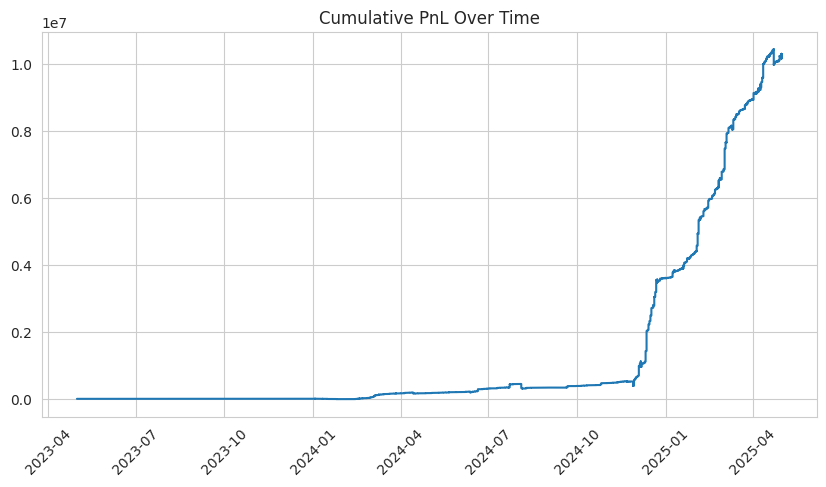

In [25]:
#Cumulative Pnl

merged_sorted = merged.sort_values('date')
merged_sorted['cumulative_pnl'] = merged_sorted['closed pnl'].cumsum()

plt.figure(figsize=(10,5))
plt.plot(merged_sorted['date'], merged_sorted['cumulative_pnl'])
plt.title("Cumulative PnL Over Time")
plt.xticks(rotation=45)
plt.show()

In [26]:
# Exposure Analysis

median_size = merged['size usd'].median()

merged['exposure_segment'] = merged['size usd'].apply(
    lambda x: 'High Exposure' if x > median_size else 'Low Exposure'
)

exposure_analysis = (
    merged
    .groupby(['classification','exposure_segment'])['closed pnl']
    .mean()
    .reset_index()
)

exposure_analysis

,classification,exposure_segment,closed pnl
0,Extreme Fear,High Exposure,61.196379
1,Extreme Fear,Low Exposure,1.157202
2,Extreme Greed,High Exposure,140.570044
3,Extreme Greed,Low Exposure,9.628661
4,Fear,High Exposure,97.025581
5,Fear,Low Exposure,3.580906
6,Greed,High Exposure,84.301244
7,Greed,Low Exposure,3.609685
8,Neutral,High Exposure,69.581271
9,Neutral,Low Exposure,2.188668


In [27]:
#Frequency Analysis

trade_counts = merged.groupby('account').size()
median_trades = trade_counts.median()

merged['freq_segment'] = merged['account'].map(
    lambda x: 'Frequent' if trade_counts[x] > median_trades else 'Infrequent'
)

freq_analysis = (
    merged
    .groupby(['classification','freq_segment'])['closed pnl']
    .mean()
    .reset_index()
)

freq_analysis

,classification,freq_segment,closed pnl
0,Extreme Fear,Frequent,34.163353
1,Extreme Fear,Infrequent,35.941979
2,Extreme Greed,Frequent,62.870911
3,Extreme Greed,Infrequent,103.264685
4,Fear,Frequent,51.323784
5,Fear,Infrequent,80.835791
6,Greed,Frequent,25.004641
7,Greed,Infrequent,210.210287
8,Neutral,Frequent,34.579701
9,Neutral,Infrequent,31.845656


In [28]:
#Performance Analysis

trader_perf = merged.groupby('account')['closed pnl'].mean()
median_perf = trader_perf.median()

merged['performance_segment'] = merged['account'].map(
    lambda x: 'Top Half' if trader_perf[x] > median_perf else 'Bottom Half'
)

performance_analysis = (
    merged
    .groupby(['classification','performance_segment'])['closed pnl']
    .mean()
    .reset_index()
)

performance_analysis

,classification,performance_segment,closed pnl
0,Extreme Fear,Bottom Half,-3.781170
1,Extreme Fear,Top Half,94.602428
2,Extreme Greed,Bottom Half,35.885548
3,Extreme Greed,Top Half,204.622229
4,Fear,Bottom Half,12.908646
5,Fear,Top Half,104.194444
6,Greed,Bottom Half,3.916305
7,Greed,Top Half,133.778498
8,Neutral,Bottom Half,5.713914
9,Neutral,Top Half,87.380159
